<a href="https://colab.research.google.com/github/HealLink/ML-Model/blob/ryan's-experiment/notebook_bert_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tensorflow[and-cuda]
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"

In [ ]:
!pip3 install tf_keras==2.18
!pip3 install --upgrade tensorflow-hub

  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached tf_keras-2.18.0-py3-none-any.whl (1.7 MB)
Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.4 MB)
Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
# Import-import
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import json

tf.get_logger().setLevel('ERROR')

2024-11-27 20:27:40.305729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732714060.324120   32456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732714060.329382   32456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 20:27:40.349005: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [6]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Step 1: Data cleaning

In [7]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

--2024-11-27 19:54:22--  https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh
Resolving drive.google.com (drive.google.com)... 74.125.68.100, 74.125.68.101, 74.125.68.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download [following]
--2024-11-27 19:54:24--  https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.68.132, 2404:6800:4003:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31469558 (30M) [application/octet-stream]
Saving to: ‘data/combined_data.csv’

data/combined_data. 100%[===================>]  30.01M  3.42MB

In [8]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [9]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Step 1a: Basic cleaning

In [11]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    362
status         0
dtype: int64
Number of duplicate rows: 1969


In [12]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [13]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    0
status       0
dtype: int64
Number of duplicate rows: 0


### Step 1b: Deep cleaning

In [14]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [15]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [16]:
def clean_text(text):
    text = text.lower()
    # remove stopwords
    for word in stopwords:
        if word[0] == "'":
            text = re.sub(rf"{word}\b", "", text)
        else:
            text = re.sub(rf"\b{word}\b", "", text)

    text = re.sub(r'[!"“’#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', ' ', text) # remove punctuation mark
    # text = re.sub(emoj, ' ', text) # remove emoji
    text = re.sub(r'\d+', ' ', text) # remove number
    # text = re.sub(r'(.)\1+', r'\1', text) # remove repeated character
    # text = re.sub(r' [a-z] ', ' ', text) # remove single character
    text = re.sub(r'\s+', ' ', text) # remove multiple spaces
    return text.strip()

In [17]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [18]:
# Data distribution analysis of each label
df.status.value_counts()

status
Normal                  15973
Depression              15086
Suicidal                10639
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [19]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [20]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [21]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

word_count_range
1-100       42531
101-200      6121
201-300      1510
301-400       474
401-500       198
501-600        78
601-700        39
701-800        22
801-900        10
901-1000        6
+1000          15
Name: count, dtype: int64

In [22]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

/tmp/ipykernel_24786/3797327473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)


status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
word_count_range,,,,,,,
1-100,2705,1677,11106,15970,589,2053,8431
101-200,672,592,2849,3,232,178,1595
201-300,159,162,720,0,47,45,377
301-400,50,41,222,0,17,9,135
401-500,21,21,84,0,7,6,59
501-600,5,4,48,0,2,0,19
601-700,2,1,23,0,0,1,12
701-800,3,2,13,0,0,0,4
801-900,0,0,8,0,0,1,1


In [25]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 256)].reset_index(drop=True)
df_export_candidate.status.value_counts()

status
Depression              13633
Suicidal                 9393
Normal                   5204
Anxiety                  3022
Bipolar                  2350
Stress                   2242
Personality disorder      831
Name: count, dtype: int64

In [26]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

Label with the lowest number of examples: Personality disorder
Number of examples: 831


In [27]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

,statement,status,word_count,word_count_range
0,mother treats like shit keep going back m f mo...,Depression,256,201-300
1,idk needed thought id add tw brief mention sui...,Depression,256,201-300
2,title post says account reddit not socialize a...,Suicidal,256,201-300
3,feel like something fundamentally broken every...,Depression,256,201-300
4,fuck wish not much damn coward many times wish...,Suicidal,256,201-300
...,...,...,...,...
5812,ve feeling miserable hopeless weekend hate jus...,Personality disorder,10,1-100
5813,philosophy interests view poll https www reddi...,Personality disorder,10,1-100
5814,neurodivergent view poll https www reddit com ...,Personality disorder,10,1-100
5815,guys ever wonder s late late fix life mess cre...,Personality disorder,10,1-100


In [28]:
df_export_candidate.status.value_counts()

status
Depression              831
Suicidal                831
Personality disorder    831
Anxiety                 831
Bipolar                 831
Stress                  831
Normal                  831
Name: count, dtype: int64

In [29]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [30]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data_10-256_removed_stopwords_punc_num_space.csv', index=False)

In [33]:
del df
del df_export_candidate

# Step 2: Create the model

In [41]:
VOCAB_SIZE = 10000
MAX_LENGTH = 256
TRAINING_SPLIT = 0.8
BATCH_SIZE = 8
SEED = 69

In [8]:
sentences = []
labels = []

with open(data_dir+'/cleaned_data_10-256_removed_stopwords_punc_num_space.csv', 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

I0000 00:00:1732714078.913528   32456 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1732714078.917173   32456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


### Step 2a: Create tf.data.Dataset

In [9]:
# Step 1: Separate by label
label_datasets = {}
for label in tf.unique(labels)[0]:
    label_datasets[label.numpy()] = dataset.filter(lambda x, y: y == label)

# Step 2: Shuffle and split each label-specific dataset
train_datasets = []
val_datasets = []
for label, ds in label_datasets.items():
    # Shuffle the data for each label
    ds = ds.shuffle(100, seed=SEED)
    
    # Calculate sizes
    size = len(list(ds.as_numpy_iterator()))
    train_size = int(size * TRAINING_SPLIT)
    
    # Split
    train_datasets.append(ds.take(train_size))
    val_datasets.append(ds.skip(train_size))

# Step 3: Combine the datasets
train_dataset = train_datasets[0]
val_dataset = val_datasets[0]
for ds in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(ds)
for ds in val_datasets[1:]:
    val_dataset = val_dataset.concatenate(ds)

train_count = train_dataset.reduce(0, lambda x, _: x + 1).numpy()
val_count = val_dataset.reduce(0, lambda x, _: x + 1).numpy()

print(f"There are {train_count} sentence-label pairs for training.")
print(f"There are {val_count} sentence-label pairs for validation.")


2024-11-27 20:28:23.359128: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-27 20:28:23.758713: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-27 20:28:24.541239: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


There are 4648 sentence-label pairs for training.
There are 1169 sentence-label pairs for validation.


In [10]:
train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = val_dataset.map(lambda statement, status: statement)
test_labels = val_dataset.map(lambda statement, status: status)

In [11]:
del sentences
del labels
del dataset

### Step 2b: Create label encoder

In [12]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.

    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)

    return label_encoder

# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['Suicidal', 'Stress', 'Personality disorder', 'Normal', 'Depression', 'Bipolar', 'Anxiety']


2024-11-27 20:29:08.697229: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-27 20:29:08.697299: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3465354219221782419
2024-11-27 20:29:08.697326: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17747520385247327136
2024-11-27 20:29:08.697335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11526668195196219048


### Step 2c: Dataset preprocessing

In [13]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_label_encoded = tf.data.Dataset.zip(train_statement,train_labels_encoded)
test_dataset_label_encoded = tf.data.Dataset.zip(test_statement,test_labels_encoded)

# print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
# print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

In [14]:
# del train_dataset_label_encoded
# del test_dataset_label_encoded
del train_labels_encoded
del test_labels_encoded

In [65]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

2024-11-27 20:14:32.821242: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-27 20:14:33.731632: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


AttributeError: 'dict' object has no attribute 'shape'

### Step 2d: Architect the model

#### Step 2d-1: Loading model - choose model to fine tune

In [15]:
bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### Step 2d-2: Preprocessing model

In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['i wanna die']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1045 10587  3280   102     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Step 2d-3: Using BERT Model

In [17]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


In [18]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


#### Step 2d-4: Defining model

In [19]:
def make_bert_preprocess_model(sentence_features, seq_length=512):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [20]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

In [21]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_type_ids', 'input_mask', 'input_word_ids']
Shape Word Ids :  (1, 512)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 512)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 512)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [45]:
classifier_model = build_classifier_model(7)
bert_raw_result = classifier_model(text_preprocessed)

print(f'Shape of the output: {bert_raw_result.shape}')
print(tf.nn.softmax(bert_raw_result))

2024-11-27 20:39:38.107385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Shape of the output: (1, 7)
tf.Tensor(
[[0.11703752 0.06509488 0.12429976 0.25432536 0.18391363 0.22195737
  0.03337148]], shape=(1, 7), dtype=float32)


In [46]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()

epochs = 10
steps_per_epoch = int(train_count / BATCH_SIZE)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [49]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# STEP IDK: tokenizing data

In [42]:
for statement, label in train_dataset_label_encoded.take(1):
    print(statement)
    print(label)

tf.Tensor(b'control fear anxiety stress always lead plain simple hi begin discussion will off top head ll adding experiences start situations life genuinely absolutely no control suffer mdd struggle daily basis take medication try get see therapist m trying find job interest m constantly worried future whether want continue not one thing happens quite frequently create non existent situations head cause even stress anxiety cycle begins doesn t matter whether control not s nightmare deal constant stress anything may happen occur humans unequipped handle challange one say society surrounded expected us causes drastic change way look feel think extent true terribly exhausting anxiety stricken able even begin coping going around us s obstacle incapable clearing worry anything everything involves close m consistently tired pain anxious worried heavy weight chest every minute everyday years nothing seems change keep telling tomorrow will different ll will better time comes fall short let let

In [43]:
#optimizing data
# Optimize the datasets for training
train_dataset_final = (train_dataset_label_encoded
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_label_encoded
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [44]:
bert_preprocess_model = make_bert_preprocess_model(['sentence'], 256)

train_dataset_final = train_dataset_final.map(lambda text, label: (bert_preprocess_model(text), label))
test_dataset_final = test_dataset_final.map(lambda text, label: (bert_preprocess_model(text), label))

In [50]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
	classifier_model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = classifier_model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-11-27 20:40:12.646347: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-27 20:40:14.977375: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (8, 7)


# Step 3: How To Train Your ~~Dragon~~ ML Model

### Callback-callback

In [33]:
# Callbacks
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.keras"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "loss": [], "sparse_categorical_accuracy": [],
                        "val_loss": [], "val_sparse_categorical_accuracy": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch)
        self.history["loss"].append(logs.get("loss"))
        self.history["sparse_categorical_accuracy"].append(logs.get("sparse_categorical_accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_sparse_categorical_accuracy"].append(logs.get("val_sparse_categorical_accuracy"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [34]:
# run this code to delete checkpoint
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

No saved epoch found


In [35]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    classifier_model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

No saved epoch found. Starting from epoch 0


### TRAIN!!!!

In [ ]:
train_steps = sum(1 for _ in train_dataset)
val_steps = sum(1 for _ in val_dataset)

history = classifier_model.fit(
    train_dataset_final,
    epochs=epochs - start_epoch,
    validation_data=test_dataset_final,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback
    ]
    )

Epoch 1/10
  11/4648 [..............................] - ETA: 7:22:17 - loss: 12.0404 - sparse_categorical_accuracy: 0.0795

In [ ]:
loss, accuracy = classifier_model.evaluate(test_dataset_final)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

75/75 [==============================] - 4s 48ms/step - loss: 0.9319 - sparse_categorical_accuracy: 0.7598
Loss: 0.9319278001785278
Accuracy: 0.7598326206207275


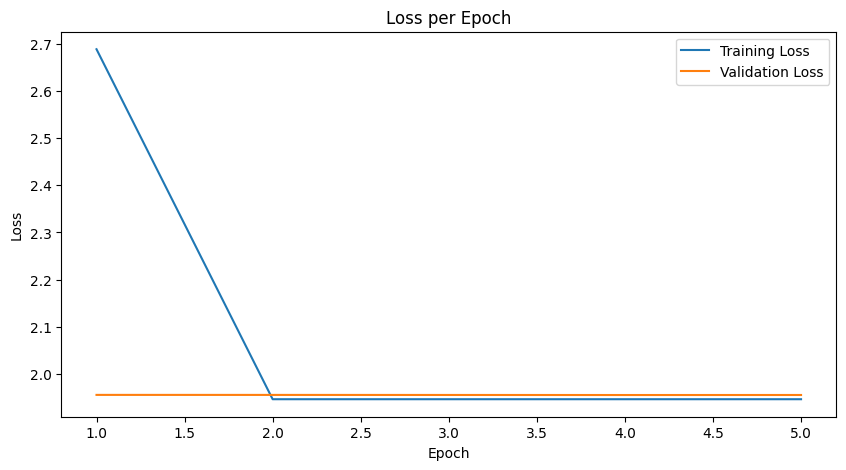

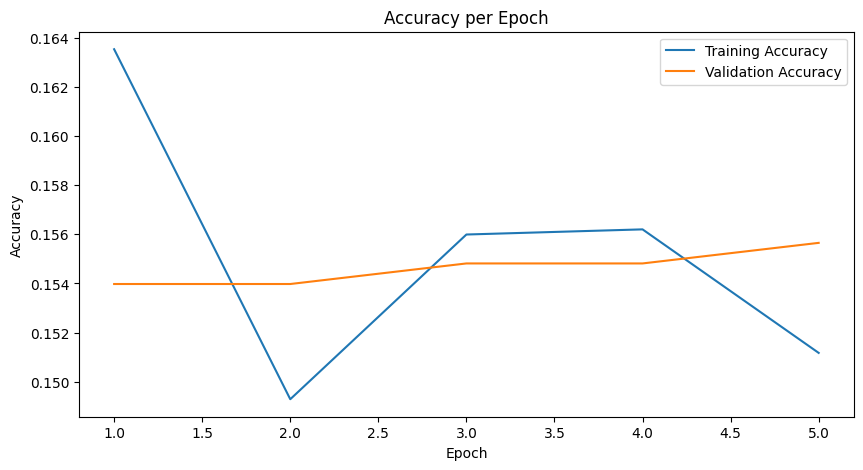

In [32]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["sparse_categorical_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 4: Test the model

In [ ]:
rawtext_test = ["i'm really nervous"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(tokenizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  47    8   51  233 1195]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 ...
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]], shape=(500, 5), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[[3.1016039e-02 1.6379152e-01 2.3748980e-01 ... 3.1037180e-02
  1.8597090e-01 1.3207725e-01]
 [1.8049697e-03 2.5665307e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696587e-04]
 [1.8049697e-03 2.5665307e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696587e-04]
 ...
 [1.8049699e-03 2.5665309e-02 2.4951806e-02 ... 4.0975236e-05
  7.0504652e-04 2.0696588e-04]
 [1.8049706e-03 2.5665324e-02 2.4951816e-02 ... 4.0975232e-05
  7.0504716e-04 2.0696585e-04]
 [1.8049706e-03 2.5665324e-02 2.4951816e-02 ... 4.0975232e-05
  7.0504710e-04 2.0696584e-04]]
Predicted class: Personality disorder


# Step 5: Done, save the model

In [ ]:
# Run this if you happy with the model
with open(data_dir+"/label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save(data_dir+'/second_iteration.keras')